In [33]:
import os
import pandas as pd

current_dir = os.getcwd()
final_path = os.path.join(current_dir, '..', 'data', 'final', 'final.csv')

final_df = pd.read_csv(final_path)

### Przygotowanie danych

In [34]:
from util import prepare_final

final_df = prepare_final(final_df)

final_df.head()

,premium_user,popularity_mean,popularity_std,popularity_min,popularity_max,duration_ms_mean,duration_ms_std,duration_ms_min,duration_ms_max,explicit_ratio,...,q,r,s,t,u,v,w,x,y,z
0,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.059379,-0.409611,-0.430490,-0.491912,-1.065425,...,0,1,0,1,1,0,1,0,0,0
1,False,1.066575,0.740434,2.270742,0.713372,0.661699,-0.043242,1.994549,-0.098518,0.176852,...,0,1,0,1,0,1,1,0,0,0
2,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.429353,-0.963033,0.339053,-0.735753,-0.814081,...,0,1,1,0,1,0,0,0,0,0
3,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.192440,-0.607767,-1.304843,-0.491912,-0.613005,...,0,1,0,1,1,1,1,0,1,0
4,False,1.056186,1.104850,0.544205,0.968310,0.678373,-0.770022,0.842162,-0.812626,2.439812,...,0,1,1,1,1,0,0,0,0,0


In [35]:
from sklearn.model_selection import train_test_split

X = final_df.drop('premium_user', axis=1)
y = final_df['premium_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Klasyfikatora Random Forest
Uczenie

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

Accuracy: 0.79
ROC AUC: 0.85


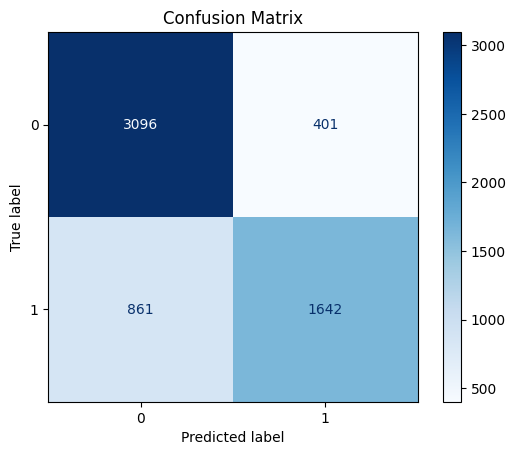

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.2f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Selekcja atrybutów

In [38]:
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

n = 25
selected_features = X_train.columns[indices][:n]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected.head()

,skip_play_ratio,like_play_ratio,city_frequency,danceability_mean,unique_track_count,unique_artist_count,explicit_count,valence_mean,speechiness_mean,instrumentalness_std,...,acousticness_mean,popularity_std,instrumentalness_mean,popularity_max,valence_std,loudness_std,danceability_std,tempo_std,acousticness_std,liveness_mean
21753,1.148967,0.893592,-0.389192,-1.021799,-0.796238,-0.636550,0.091560,-1.284575,-0.778886,-0.403777,...,-1.029090,1.149934,-0.541855,1.121273,0.657873,-0.289353,0.702547,-0.064918,-0.876905,1.599924
251,1.276084,0.732191,0.102809,-0.930207,-0.272982,-0.423377,0.201087,-0.771339,-1.079239,-0.877007,...,-1.016714,1.235745,-0.916972,1.121273,0.452280,-1.103128,-0.621992,0.938075,-1.174079,0.123498
22941,1.310879,0.870949,0.544605,-1.440138,0.168194,0.024288,0.201087,-0.950466,-0.768272,-1.433380,...,-1.032443,0.974179,-1.161595,1.044791,-0.312605,-1.052244,-0.460167,0.486191,-1.297450,2.833155
618,1.241430,0.982545,1.182197,-1.188012,0.794049,0.962253,1.077297,-0.809741,-0.927810,-1.345166,...,-1.021179,0.866417,-1.099546,1.121273,-0.730487,-0.555151,-1.172395,0.279101,-0.906347,-0.335711
17090,-0.886245,-1.072747,-1.322988,1.205763,-1.360533,-1.382658,-0.784650,1.716267,1.045649,1.113183,...,1.062402,-0.995204,0.942475,-0.994713,-0.797447,1.103620,0.732714,0.529029,0.403582,-1.307060


In [39]:
clf_selected = RandomForestClassifier()
clf_selected.fit(X_train_selected, y_train)

y_pred_selected = clf_selected.predict(X_test_selected)
y_pred_proba_selected = clf_selected.predict_proba(X_test_selected)[:, 1]

Accuracy: 0.79
ROC AUC: 0.85


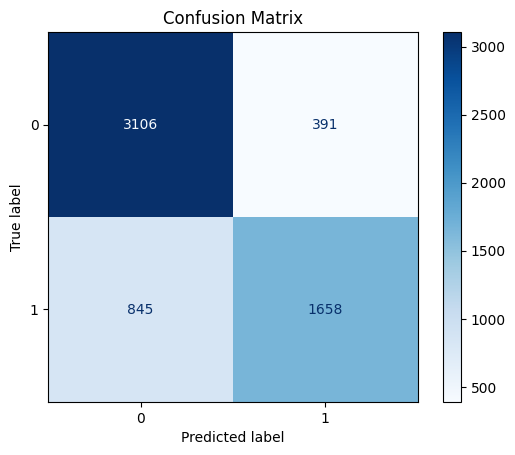

In [40]:
accuracy = accuracy_score(y_test, y_pred_selected)
print(f'Accuracy: {accuracy:.2f}')

roc_auc = roc_auc_score(y_test, y_pred_proba_selected)
print(f'ROC AUC: {roc_auc:.2f}')

cm = confusion_matrix(y_test, y_pred_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [41]:
selected_path = os.path.join(current_dir, '..', 'data', 'final', 'selected.csv')
X_selected = X[selected_features]
X_selected.to_csv(selected_path, index=False)

Index(['skip_play_ratio', 'like_play_ratio', 'city_frequency',
       'danceability_mean', 'unique_track_count', 'unique_artist_count',
       'explicit_count', 'valence_mean', 'speechiness_mean',
       'instrumentalness_std', 'energy_mean', 'release_year_median',
       'tempo_mean', 'loudness_mean', 'duration_ms_mean', 'acousticness_mean',
       'popularity_std', 'instrumentalness_mean', 'popularity_max',
       'valence_std', 'loudness_std', 'danceability_std', 'tempo_std',
       'acousticness_std', 'liveness_mean'],
      dtype='object')


<Axes: >

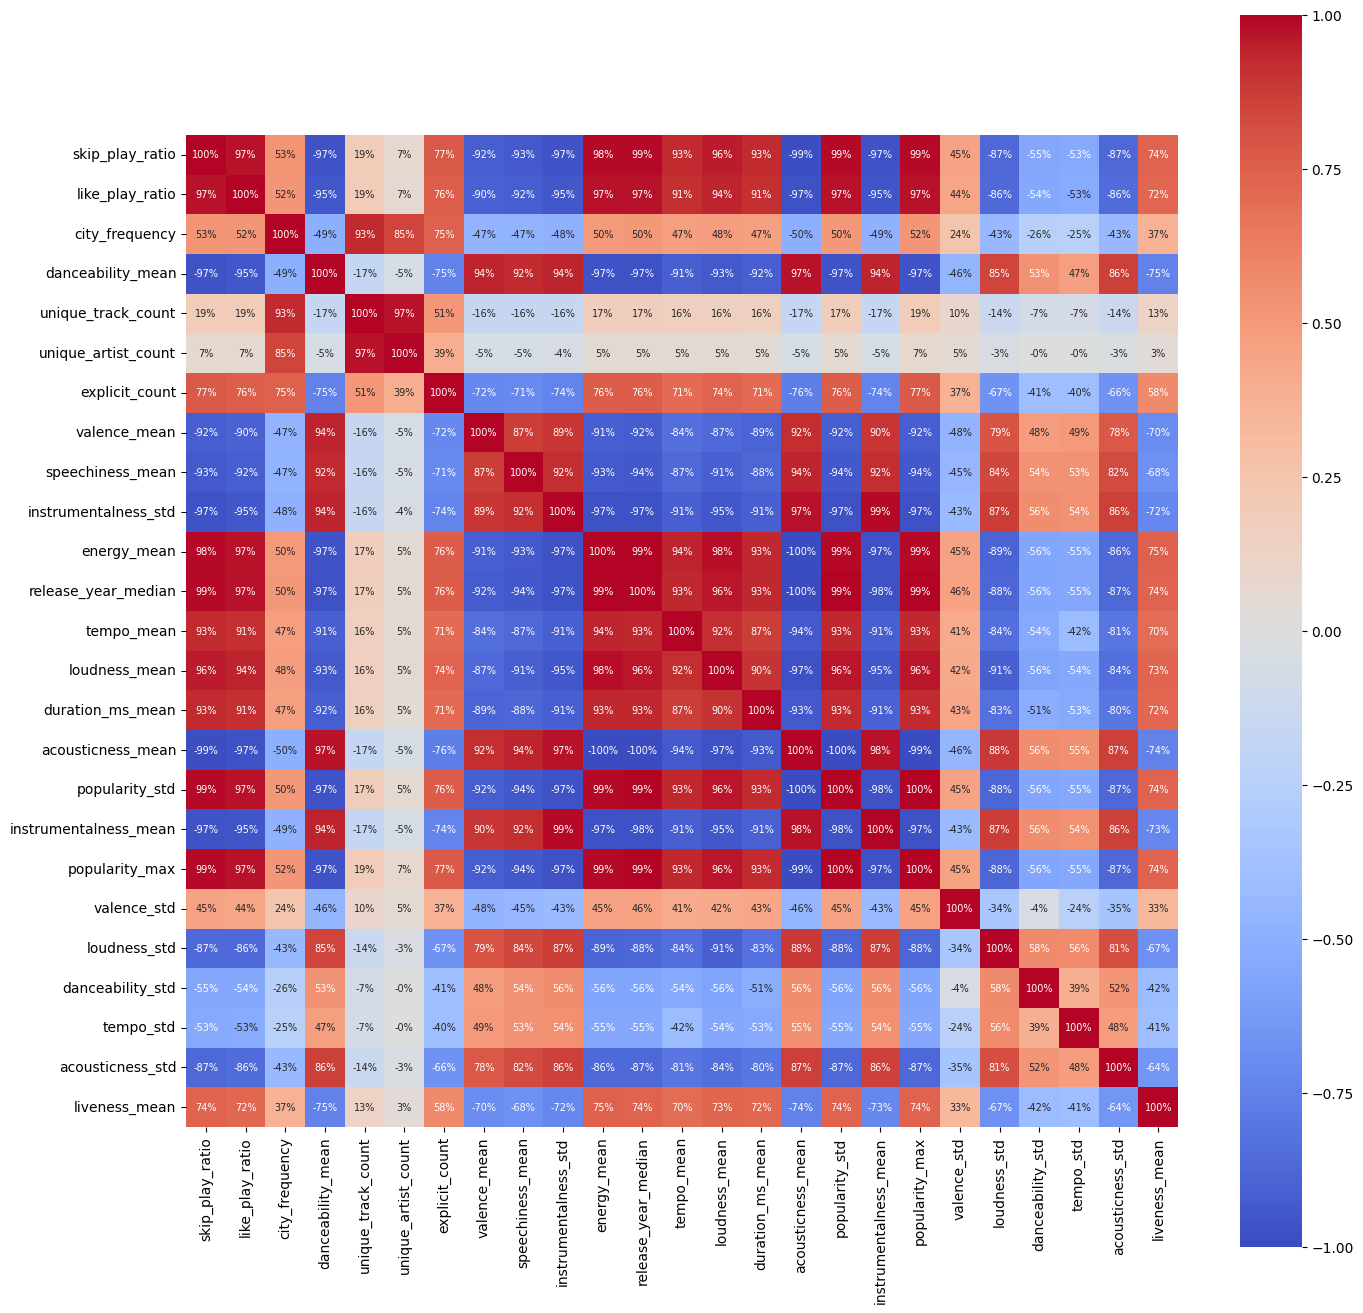

In [42]:
import seaborn as sns

continuous_fields = X_selected.select_dtypes(include=['float64', 'int64'])

print(continuous_fields.columns)

corr_matrix = continuous_fields.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, annot=True, annot_kws={'fontsize': 7}, fmt='.0%', vmin=-1, vmax=1)

Save models

In [43]:
import joblib

model_path = os.path.join(current_dir, 'trained', 'rf_model.joblib')
model_selected_path = os.path.join(current_dir, 'trained', 'rf_selected_model.joblib')

joblib.dump(clf, model_path)
joblib.dump(clf_selected, model_selected_path)

['c:\\_prog\\vm_shared\\Account-Classifier\\models\\trained\\rf_selected_model.joblib']